In [1]:
import logging
from torch.utils.data import DataLoader
import torch
import numpy as np

import os
import sys
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

sys.path.append('/Data/reds_dataset/6.8300-Computer-Vision/src/')

from data_handlers.loading import MultiStageVideoDataset
from models import MultiStageBasicVSRAnalysis

In [2]:
val_dataset = MultiStageVideoDataset(
        lr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='/Data/reds_dataset/6.8300-Computer-Vision/data/processed/train/train_sharp',
        rolling_window=5,
        is_test=False,
        is_val=True,
        patch_size=64,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

model = MultiStageBasicVSRAnalysis(
        spynet_pretrained='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/spynet_20210409-c6c1bd09.pth',
        pretrained_bvsr='/Data/reds_dataset/6.8300-Computer-Vision/checkpoints/basicvsr_custom_spynet.pth',
        rolling_window=5,
    )

state_dict = torch.load('/Data/reds_dataset/6.8300-Computer-Vision/results_best/multistage_bvsr_trial_fixed/models/model_20.pth')
state_dict = {k.replace('_orig_mod.',''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to('cuda')

model = model.eval()
model = model.requires_grad_(False)

In [3]:
!nvidia-smi

Fri May 12 19:57:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   43C    P2    94W / 350W |    815MiB / 24576MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# criterion = CharbonnierLoss()
device = 'cuda'
psnrs = []
psnrs_bis = []
mse = nn.MSELoss()

for idx, data in enumerate(val_loader):
    gt_sequences, lq_sequences = data[1], data[0]
    gt_sequences = gt_sequences.to(device)
    (in_1, in_2, in_3) = (lq_sequences[0].to(device), lq_sequences[1].to(device), lq_sequences[2].to(device))    
    out, attention_output, M, (first_conv, second_conv, third_conv), res, (output_1, output_2, output_3), base = model((in_1, in_2, in_3))
    gt_sequences = gt_sequences.squeeze(1)
    break
    loss = mse(out, gt_sequences)
    loss_bis = mse(res, gt_sequences)
    psnrs.append((10*torch.log(1/loss)/torch.log(torch.Tensor([10]).to('cuda'))).cpu().detach().numpy())
    psnrs_bis.append((10*torch.log(1/loss_bis)/torch.log(torch.Tensor([10]).to('cuda'))).cpu().detach().numpy())
#print(f'Average validation PSNR: {np.mean(psnrs)}dB')
#print(f'Average validation PSNR: {np.mean(psnrs_bis)}dB')


/users/eleves-a/2019/paul.theron/miniconda3/envs/computer_vision/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Attention output analysis

In [7]:
attention_output = attention_output.squeeze()
attention_output.shape

torch.Size([64, 180, 320])

In [ ]:
# print the 16 first channels of the attention output
att_subset = attention_output[:16, :, :].permute(1, 2, 0).cpu().detach().numpy()

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(att_subset[:, :, i*4+j])
        axs[i, j].set_title(f'Attention map {i*4+j}')
        axs[i, j].axis('off')

### Analysis of the attention masks

In [13]:
M = M.squeeze()
M_1 = M[0]
M_2 = M[1]
M_3 = M[2]

first_conv_ = first_conv.squeeze(0).squeeze(0)
second_conv_ = second_conv.squeeze(0).squeeze(0)
third_conv_ = third_conv.squeeze(0).squeeze(0)

output_1_ = output_1.squeeze(0)
output_2_ = output_2.squeeze(0)
output_3_ = output_3.squeeze(0)
    


torch.Size([3, 64, 180, 320])


In [26]:
input_cat = torch.cat(
            [output_1_.unsqueeze(0), output_2_.unsqueeze(0), output_3_.unsqueeze(0)], dim=0
)

# calculate the pointwise multiplication of the attention masks with the input
elemwise_mult = torch.mul(M, input_cat)



torch.Size([3, 64, 180, 320])
torch.Size([3, 64, 180, 320])


In [ ]:
# print on 4 columns, (output, conv, M, M*output)
# do 3 groups of 3 lines (one line for each stage), and one group for 4 different channels
fig, axs = plt.subplots(9, 4, figsize=(20, 20))
for i in range(0, 9, 3):
    axs[i, 0].imshow(output_1_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i, 0].set_title(f'Output 1, channel {i}')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(first_conv_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i, 1].set_title(f'Conv 1, channel {i}')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(M_1[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i, 2].set_title(f'M 1, channel {i}')
    axs[i, 2].axis('off')
    axs[i, 3].imshow((elemwise_mult[0][i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy()))
    axs[i, 3].set_title(f'M*output 1, channel {i}')
    axs[i, 3].axis('off')
    
    axs[i+1, 0].imshow(output_2_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i+1, 0].set_title(f'Output 2, channel {i}')
    axs[i+1, 0].axis('off')
    axs[i+1, 1].imshow(second_conv_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i+1, 1].set_title(f'Conv 2, channel {i}')
    axs[i+1, 1].axis('off')
    axs[i+1, 2].imshow(M_2[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i+1, 2].set_title(f'M 2, channel {i}')
    axs[i+1, 2].axis('off')
    axs[i+1, 3].imshow((elemwise_mult[1][i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy()))
    axs[i+1, 3].set_title(f'M*output 2, channel {i}')
    axs[i+1, 3].axis('off')
    
    axs[i+2, 0].imshow(output_3_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i+2, 0].set_title(f'Output 3, channel {i}')
    axs[i+2, 0].axis('off')
    axs[i+2, 1].imshow(second_conv_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i+2, 1].set_title(f'Conv 3, channel {i}')
    axs[i+2, 1].axis('off')
    axs[i+2, 2].imshow(M_3[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i+2, 2].set_title(f'M 3, channel {i}')
    axs[i+2, 2].axis('off')
    axs[i+2, 3].imshow((elemwise_mult[2][i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy()))
    axs[i+2, 3].set_title(f'M*output 3, channel {i}')
    axs[i+2, 3].axis('off')    
    
    
   

### Plot the residuals

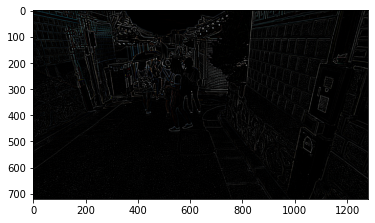

In [11]:
#plot the res in 3 colors
res_ = 2*res.squeeze(0)
plt.imshow(res_.permute(1,2,0).cpu().detach().numpy())


In [5]:
upsampled_img = model.img_upsample(in_1[:, 2, :, :, :])

In [6]:
upsampled_img = upsampled_img.squeeze(0)

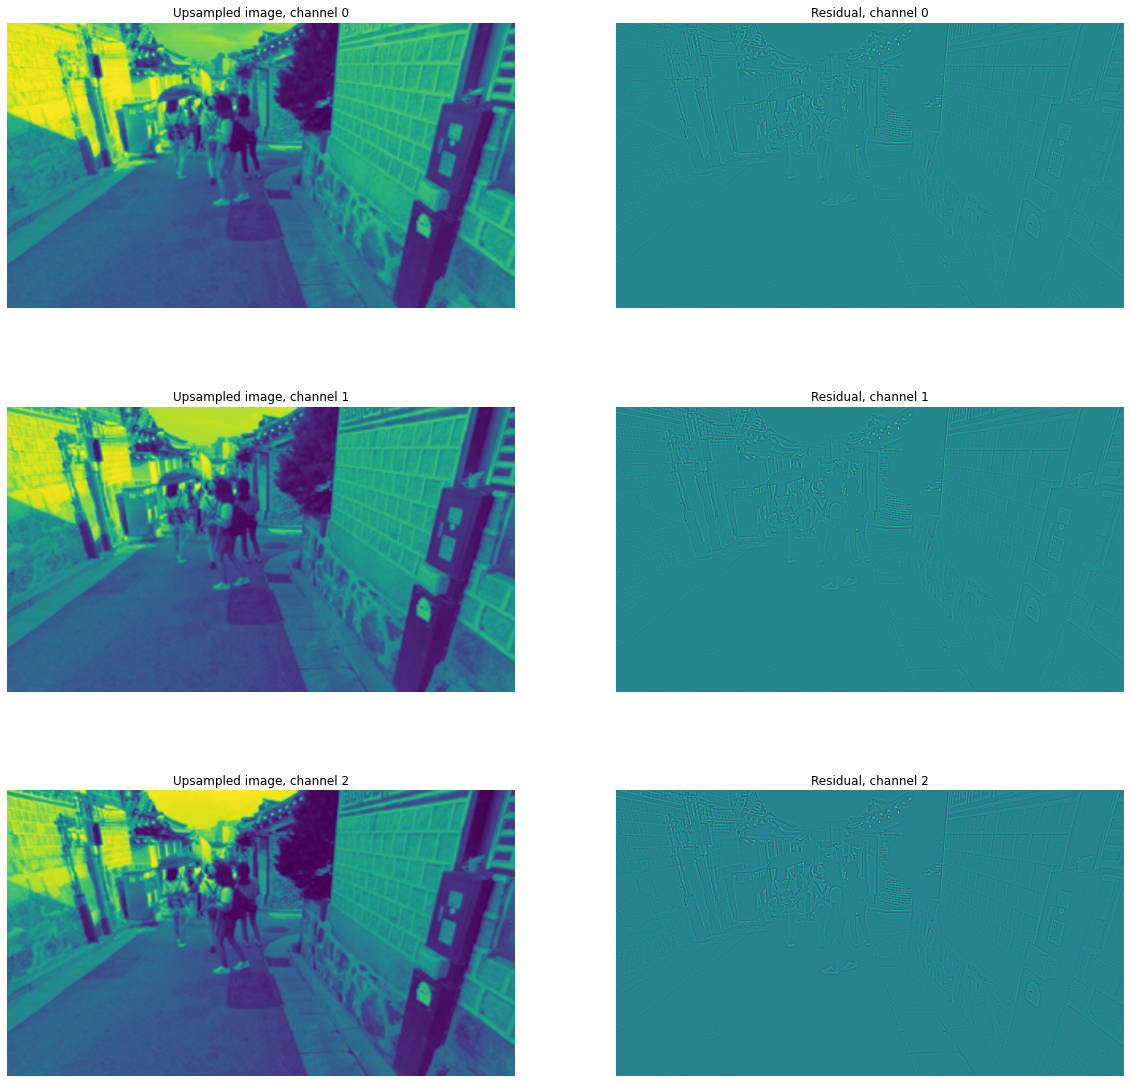

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i in range(3):
    axs[i, 0].imshow(upsampled_img[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i, 0].set_title(f'Upsampled image, channel {i}')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(res_[i].unsqueeze(0).permute(1,2,0).cpu().detach().numpy())
    axs[i, 1].set_title(f'Residual, channel {i}')
    axs[i, 1].axis('off')